The codes have been taken from this tutorial
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_epipolar_geometry/py_epipolar_geometry.html

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

In [3]:
img1 = cv2.imread('Images/Im1.JPG',0) 
img2 = cv2.imread('Images/Im2.JPG',0) 
img1=img1[1000::2,0:3000:2]
img2=img2[1000::2,0:3000:2]

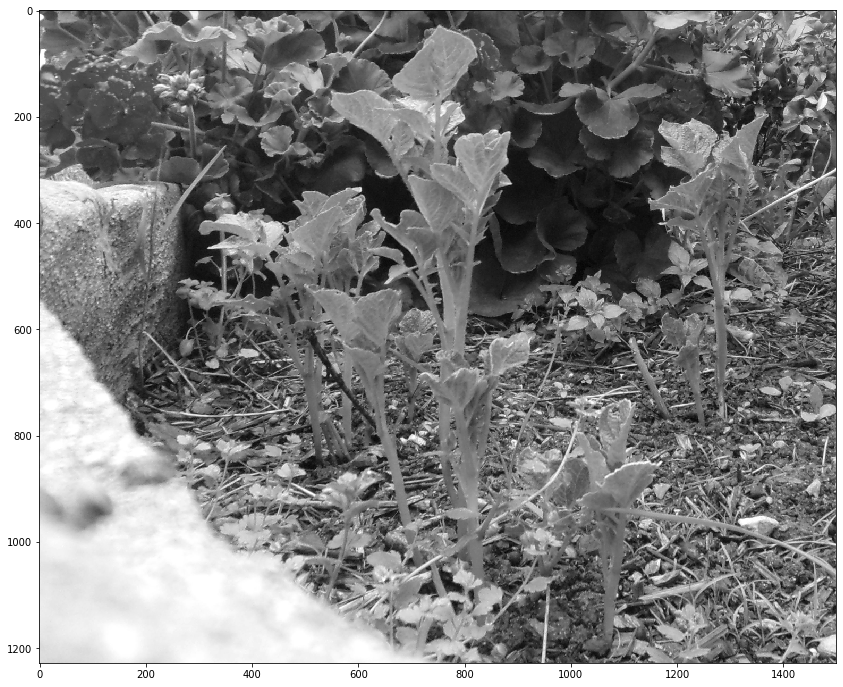

In [4]:
plt.figure(figsize=(15,12))
plt.imshow(img2,cmap=cm.gray)

In [5]:
sift = cv2.xfeatures2d.SIFT_create() 
# instead of sift = cv2.sift, need to install opencv-contrib-python with pip install -U opencv-contrib-python==3.4.2.17

In [6]:
sift.detectAndCompute

<function xfeatures2d_SIFT.detectAndCompute>

In [7]:
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

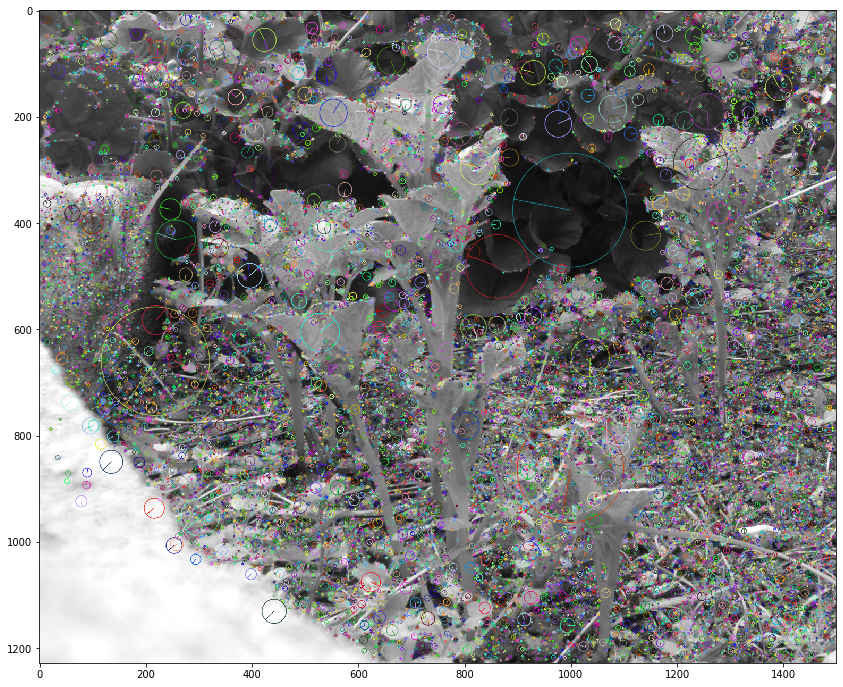

In [8]:
#gray= cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
img=cv2.drawKeypoints(img1,kp1,np.array([]),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(15,12))
plt.imshow(img)

In [9]:
# Be careful, it takes 5-10min

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)



In [10]:
good = []
pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.25*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
print(len(good))

241


In [11]:
F, mask = cv2.findFundamentalMat(np.int32(pts1),np.int32(pts2),cv2.FM_LMEDS)

In [12]:
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

In [13]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

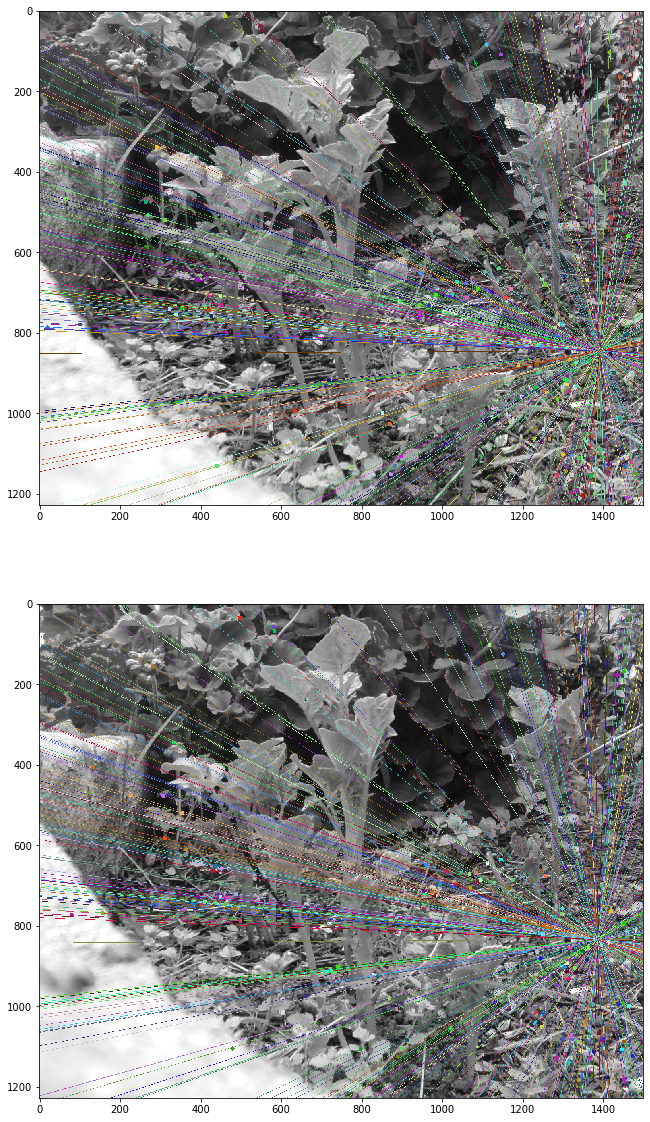

In [14]:
# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2,pts2,pts1)

plt.figure(figsize=(15,20))
plt.subplot(211),plt.imshow(img5)
plt.subplot(212),plt.imshow(img3)
plt.show()

In [15]:
M, mask = cv2.findHomography(np.int32(pts1), np.int32(pts2), cv2.RANSAC, 5.0)

In [16]:
print(F), print(M)

[[ 2.23825707e-07  6.55255055e-05 -5.57366226e-02]
 [-6.56867695e-05 -1.22492553e-09  9.14726136e-02]
 [ 5.45279342e-02 -9.09525002e-02  1.00000000e+00]]
[[ 9.48098925e-01  5.78382496e-03  5.51111083e+01]
 [-2.90865098e-03  9.57997782e-01  2.33500707e+01]
 [-7.04847965e-06  4.82695188e-06  1.00000000e+00]]


(None, None)

In [17]:
img1warped=cv2.warpPerspective(img1, M,dsize=(img1.shape[1],img1.shape[0]) )

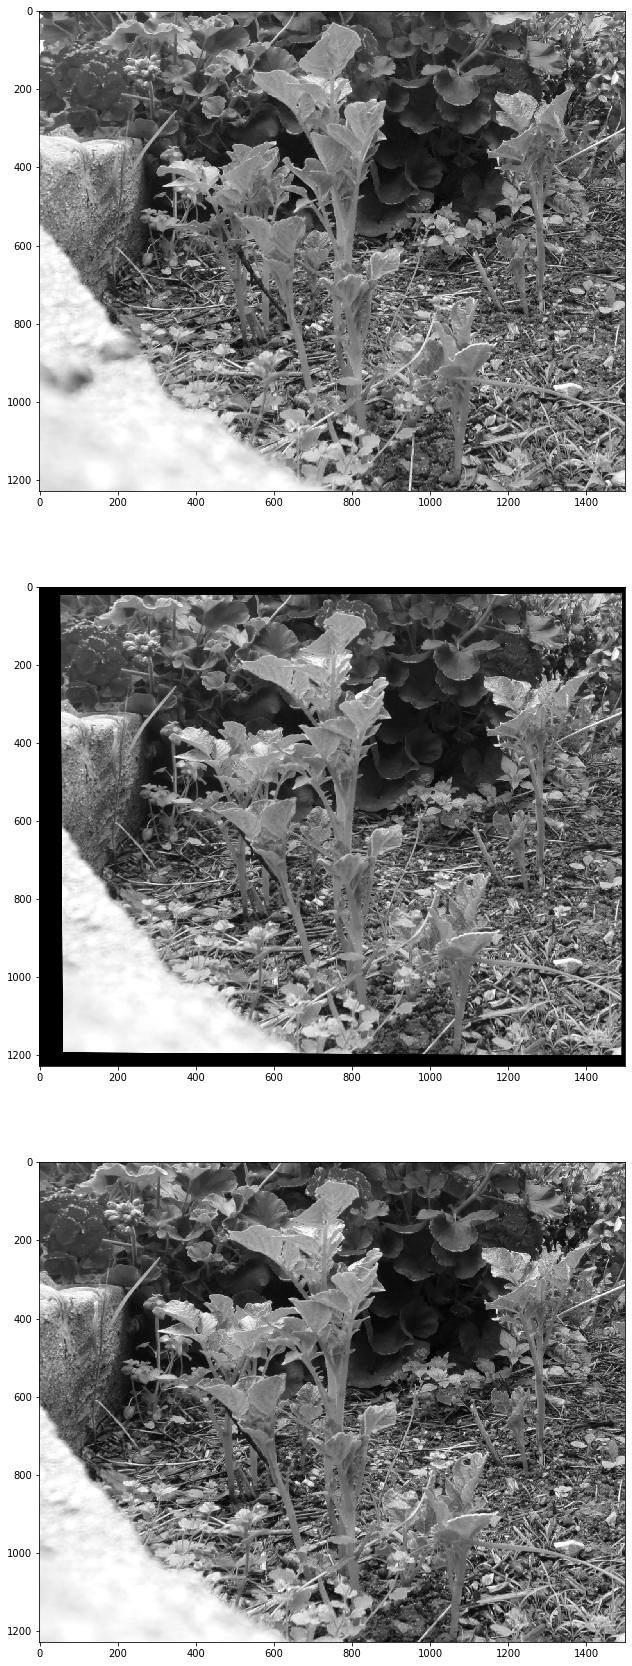

In [18]:
plt.figure(figsize=(15,30))
plt.subplot(311)
plt.imshow(img2,cmap=cm.gray)
plt.subplot(312)
plt.imshow(img1warped,cmap=cm.gray)
plt.subplot(313)
plt.imshow(img1,cmap=cm.gray)

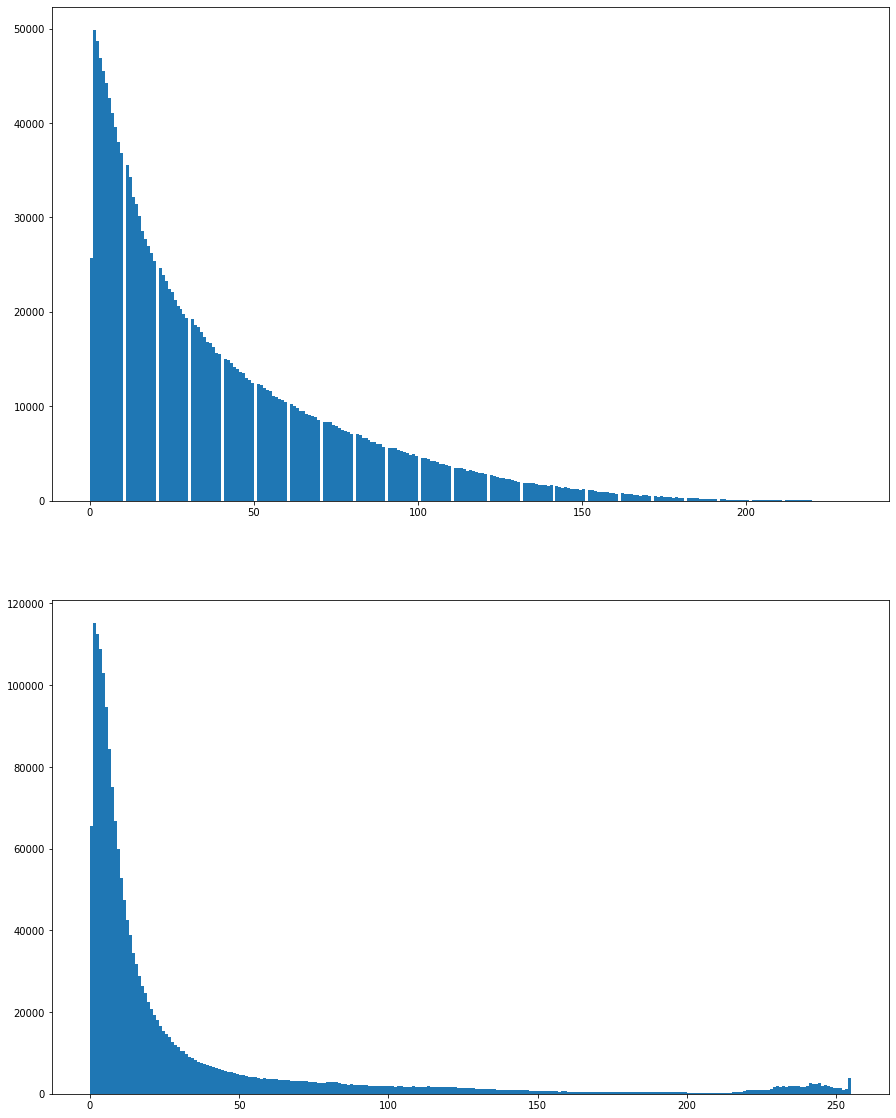

In [54]:
img1=np.array(img1,dtype=np.int32)
img2=np.array(img2,dtype=np.int32)
img1warped=np.array(img1warped,dtype=np.int32)

plt.figure(figsize=(15,20))
plt.subplot(211)
plt.hist(np.abs(img1-img2).flatten(),255)
#plt.colorbar()
plt.subplot(212)
plt.hist(np.abs(img1warped-img2).flatten(),255)
plt.show()
#plt.colorbar()

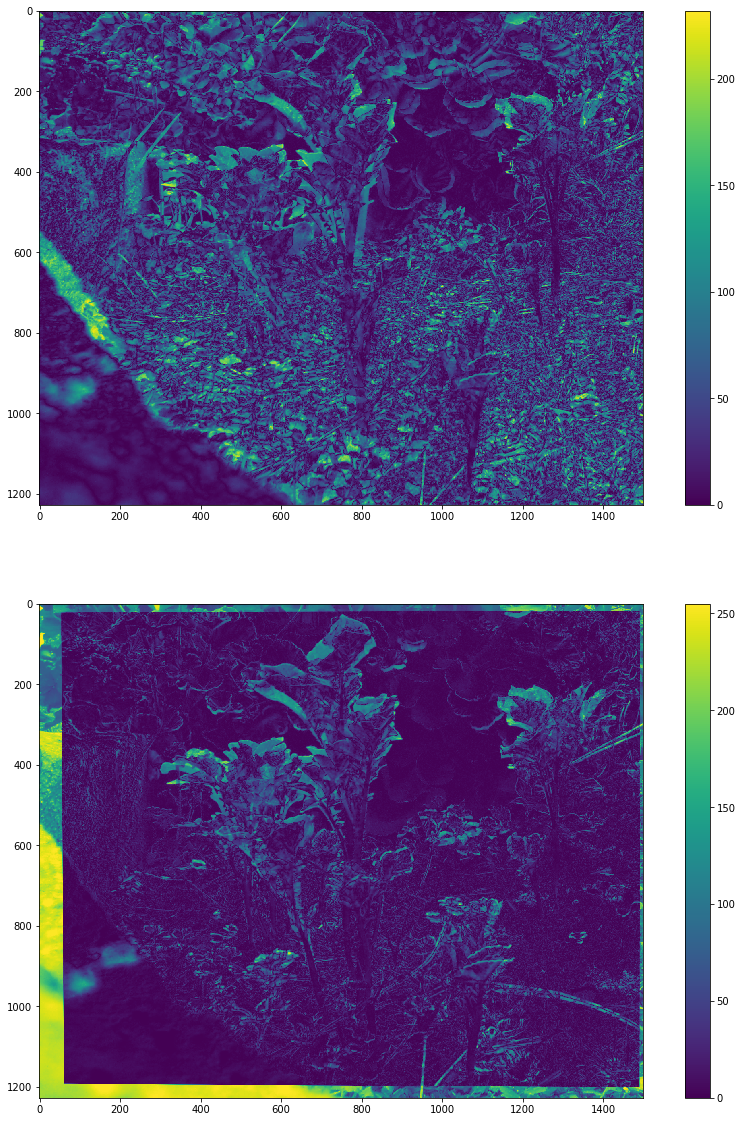

In [55]:
plt.figure(figsize=(15,20))
plt.subplot(211)
plt.imshow(np.abs(-img1+img2))
plt.colorbar()
plt.subplot(212)
plt.imshow(np.absolute(-img1warped+img2))
plt.colorbar()